In [28]:
import tensorflow as tf
import tensorflow.keras as keras

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [29]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = keras.utils.get_file("facades.tar.gz", origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), "facades/")

In [30]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [31]:
path_to_zip?

Type:        str
String form: /home/josh/.keras/datasets/facades.tar.gz
Length:      41
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.


In [32]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    print(tf.shape(image))
    w = w //2
    
    real_image = image[:, :w, :]
#     print(real_image)
    input_image = image[:, w:, :]
#     print(input_image)
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

tf.Tensor([256 512   3], shape=(3,), dtype=int32)


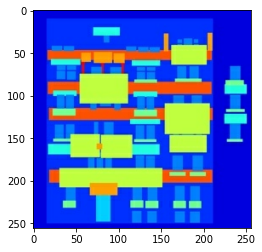

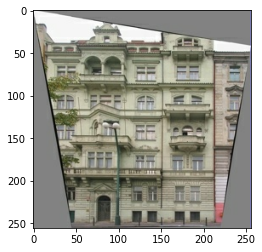

In [33]:
inp, re = load(PATH + "train/100.jpg")
plt.figure()
plt.imshow(inp/ 255.0)
plt.figure()
plt.imshow(re / 255)

In [34]:
input_image, real_image = normalize(inp, re)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


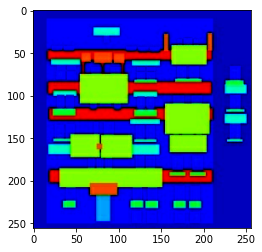

In [35]:
plt.imshow(input_image)

In [36]:
inp?

Type:            EagerTensor
String form:    
tf.Tensor(
           [[[  7.   6. 172.]
           [  0.   0. 222.]
           [  0.   0. 222.]
           ...
           [  0.   0. 222.]
           [  <...> .
           [  0.   0. 222.]
           [  0.   0. 222.]
           [  0.   0. 222.]]], shape=(256, 256, 3), dtype=float32)
Length:          256
File:            ~/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/framework/ops.py
Docstring:       <no docstring>
Class docstring: Base class for EagerTensor.


In [37]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [38]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]

In [39]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

In [40]:
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

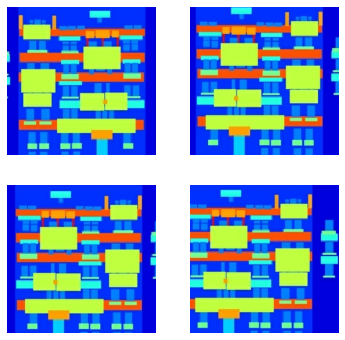

In [41]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis("off")
plt.show()

In [42]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [43]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [44]:
train_dataset = tf.data.Dataset.list_files(PATH + "train/*.jpg")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Tensor("Shape_1:0", shape=(3,), dtype=int32)


In [45]:
test_dataset = tf.data.Dataset.list_files(PATH + "test/*.jpg").map(load_image_test).batch(BATCH_SIZE)

Tensor("Shape_1:0", shape=(3,), dtype=int32)


In [60]:
train_dataset?

Type:           BatchDataset
String form:    <BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>
File:           ~/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py
Docstring:      A `Dataset` that batches contiguous elements from its input.
Init docstring: See `Dataset.batch()` for details.


In [47]:
OUTPUT_CHANNELS = 3

In [48]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(keras.layers.Conv2D(filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(keras.layers.BatchNormalization())
    result.add(keras.layers.LeakyReLU())
    
    return result

In [49]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))

In [50]:
down_result.shape, inp.shape

(TensorShape([1, 128, 128, 3]), TensorShape([256, 256, 3]))

In [51]:
# tf.expand_dims(inp, 2).shape

In [52]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))
    result.add(keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(keras.layers.Dropout(0.5))
    result.add(keras.layers.ReLU())
    
    return result

In [53]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
up_result.shape

TensorShape([1, 256, 256, 3])

In [54]:
def Generator():
    inputs = keras.layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64) bs --> batch size
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding="same", kernel_initializer=initializer, activation="tanh") # (bs, 256, 256, 3)
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

In [55]:
inputs = keras.layers.Input(shape=[256, 256, 3])
inputs    

<tf.Tensor 'input_5:0' shape=(None, 256, 256, 3) dtype=float32>

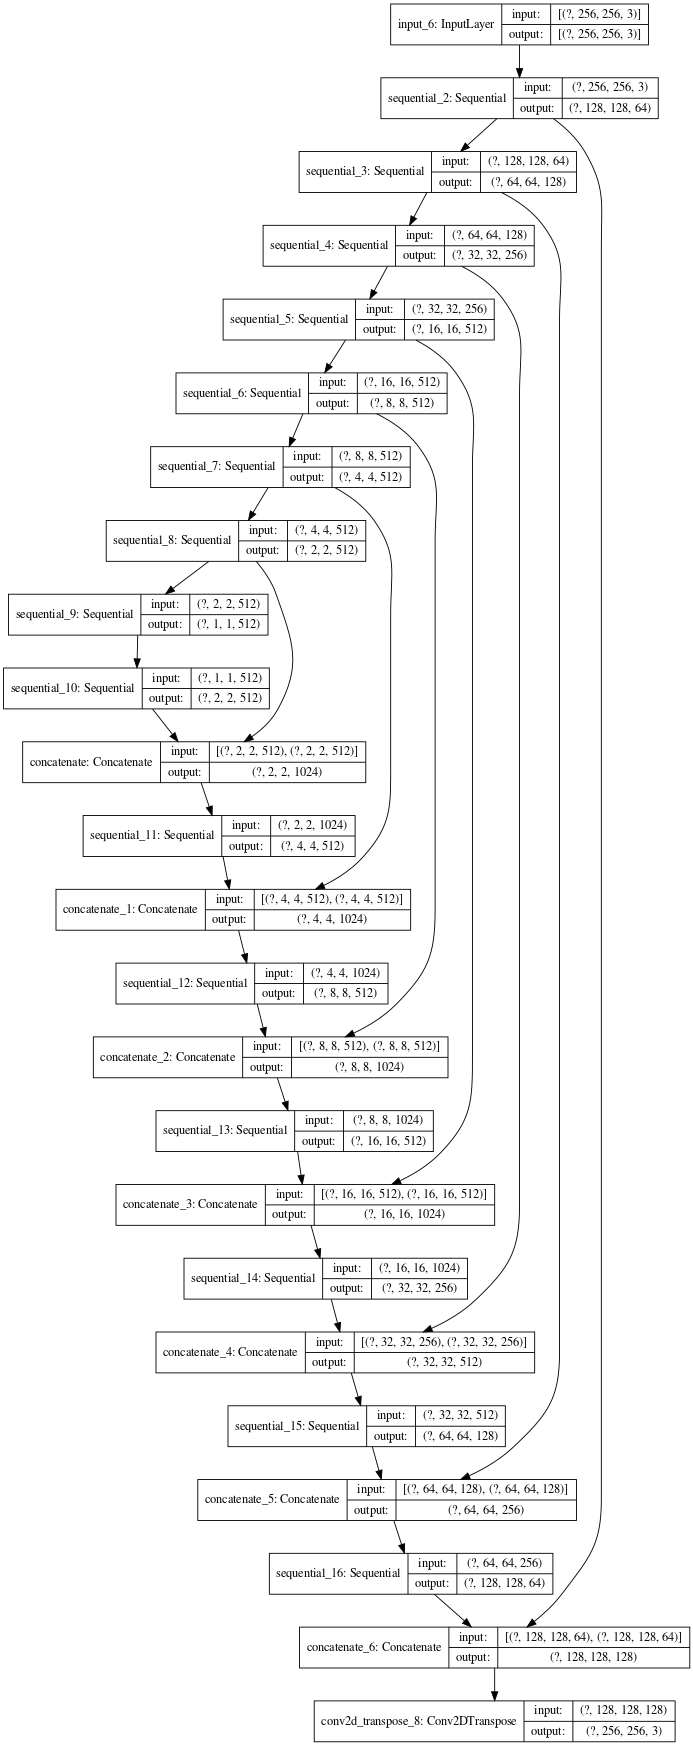

In [56]:
generator = Generator()
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [59]:
print(generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


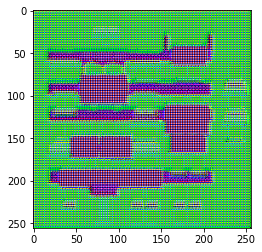

In [68]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [77]:
gen_output.numpy().min(), gen_output.numpy().max()

(-1.0, 1.0)

In [62]:
inp[tf.newaxis, ...].shape

TensorShape([1, 256, 256, 3])

In [63]:
LAMBDA = 100

In [64]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

In [65]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = keras.layers.Input(shape=[256, 256, 3], name="input_image")
    tar = keras.layers.Input(shape=[256, 256, 3], name="target_image")
    
    x = keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)
    
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)   # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)   # (bs, 32, 32, 256)
    
    zero_pad1 = keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    batchnorm1 = keras.layers.BatchNormalization()(conv)
    leaky_relu = keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    
    last = keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)
    
    return keras.Model(inputs=[inp, tar], outputs=last)

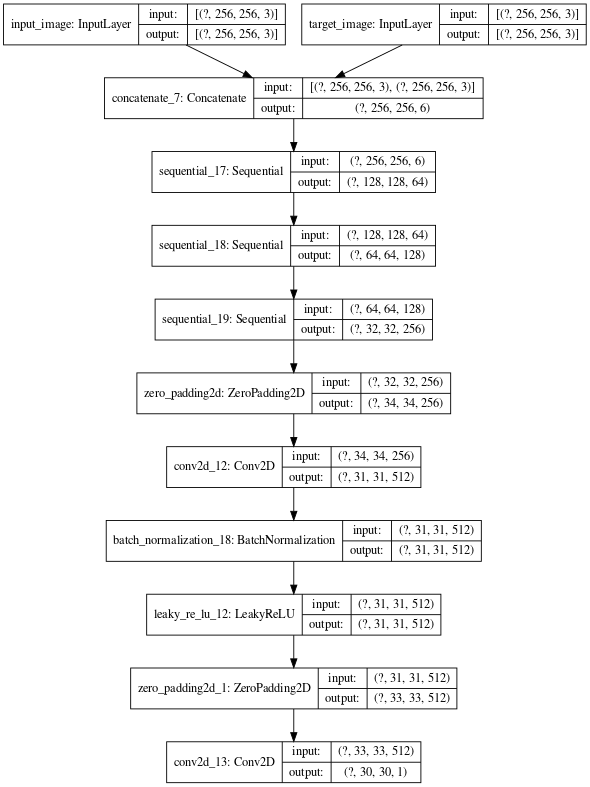

In [66]:
discriminator = Discriminator()
keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

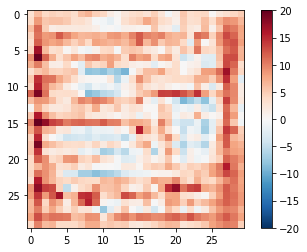

In [69]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()

In [71]:
disc_out.shape

TensorShape([1, 30, 30, 1])

In [57]:
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

In [58]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [59]:
generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

In [60]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, 
                                 generator=generator, discriminator=discriminator)

In [61]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicted Image"]
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)  #upscale to [0,1]
        plt.axis("off")
    plt.show()

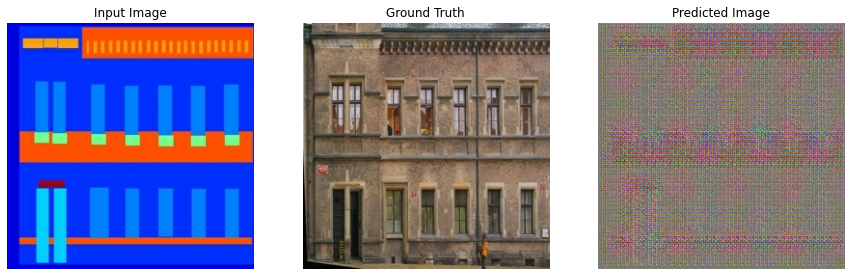

In [62]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [63]:
EPOCHS = 150

In [65]:
import datetime
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [70]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_ouput = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_ouput, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step=epoch)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step=epoch)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step=epoch)
        tf.summary.scalar("disc_loss", disc_loss, step=epoch)

In [67]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        display.clear_output(wait=True)
        
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)
        
        #Train
        for n, (input_image, target) in train_ds.enumerate():
            print(".", end="")
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()
        
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print("Time taken for epoch {} is {} sec\n".format(epoch + 1, time.time() - start))
        
    checkpoint.save(file_prefix = checkpoint_prefix)

In [69]:
fit(train_dataset, EPOCHS, test_dataset)

In [18]:
a = tf.random_normal_initializer(0., 0.02)
a?

Signature:      a(shape, dtype=tf.float32)
Type:           RandomNormal
String form:    <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7fec04ef9820>
File:           ~/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/ops/init_ops_v2.py
Docstring:     
Initializer that generates tensors with a normal distribution.

Initializers allow you to pre-specify an initialization strategy, encoded in
the Initializer object, without knowing the shape and dtype of the variable
being initialized.

Examples:

>>> def make_variables(k, initializer):
...   return (tf.Variable(initializer(shape=[k], dtype=tf.float32)),
...           tf.Variable(initializer(shape=[k, k], dtype=tf.float32)))
>>> v1, v2 = make_variables(3,
...                         tf.random_normal_initializer(mean=1., stddev=2.))
>>> v1
<tf.Variable ... shape=(3,) ... numpy=array([...], dtype=float32)>
>>> v2
<tf.Variable ... shape=(3, 3) ... numpy=
...
>>> make_variables(4, tf.random_uniform_initializer(minva